# **Stop Teaching Your Portfolio to Walk**

A simple quantitative investigation into whether reinforcement learning provides any structural advantage in trading for price-taking investors - or whether it is mathematically indistinguishable from a multi-arm bandit.

##  **Part 0: Imports**

### **• Libraries and Module Imports:**

Importing the necessary libraries and modules.

In [1]:
# Imports:
import sys, os
sys.path.append(os.path.abspath("../src"))

import numpy as np
import matplotlib.pyplot as plt
from catppuccin.extras.matplotlib import CATPPUCCIN_STYLE_DIRECTORY

from environment import simulate_price_taker
from agents import bandit_strategy, q_learning
from metrics import sharpe_ratio, cumulative_pnl, max_drawdown
from experiments import run_trials, test_hypothesis

plt.style.use(CATPPUCCIN_STYLE_DIRECTORY / "mocha.mplstyle")
np.random.seed(42)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part 1: Definitions**

A **multi-arm bandit strategy** is a simplified approach to problems where an agent chooses one of K actions (arms) and recieves an award. The key property is that the agent's action does not influence the future state - each round is independent.

The agent's only goal is to maximise immediate expected reward:

$$a_t^* = \arg\max_a ; \mathbb{E}[R_t \mid A_t = a]$$

This is implemented via *bandit_strategy*, which via momentum looks at the sign of the last return and bets in the same direction, chasing immediate reward with no planning over future states.

**Q-Learning** is a model-free RL algorithm that learns an action-value function $Q(s, a)$ - the expected cumulative discounted future reward from taking action $a$ in state $s$ and behaving optimally thereafter. It is the standard method for solving Markov Decision Processes (MDPs) where the agent's actions can influence future states.

This is implemented via the *q_learning* function and does the following:

1. Discretises the last return into a state $s \in {-1, 0, +1}$
2. Uses $\varepsilon$-greedy exploration ($\varepsilon = 0.1$) to pick action $a \in {-1, +1}$ (sell or buy)
3. Observes reward $r_t = a_t \cdot \Delta P_t$ and the next state $s'$
4. Updates the Q-table via the TD(0) Bellman update

The core of Q-Learning is the Bellman optimality equation for the action-value function:

$$Q(s, a) = \mathbb{E}\Big[R_{t+1} + \gamma \max_{a'} Q(S_{t+1}, a') \Big| S_t = s,; A_t = a\Big]$$

The TD(0) update rule that approximates this is:

$$Q(s, a) \leftarrow Q(s, a) + \alpha \Big[\underbrace{r_{t+1} + \gamma \max_{a'} Q(s', a')}_{\text{TD target}} - Q(s, a)\Big]$$

where:

$\alpha = 0.1$ is the learning rate
$\gamma = 0.95$ is the discount factor
$r_{t+1}$ is the immediate reward
$s'$ is the next state

In [ ]:
# Single run simulation
prices = simulate_price_taker()

bandit_rewards = bandit_strategy(prices)
rl_rewards = q_learning(prices)

bandit_pnl = cumulative_pnl(bandit_rewards)
rl_pnl = cumulative_pnl(rl_rewards)

print(f"Bandit  | Sharpe: {sharpe_ratio(bandit_rewards):.4f} | MaxDD: {max_drawdown(bandit_pnl):.2f}")
print(f"RL      | Sharpe: {sharpe_ratio(rl_rewards):.4f} | MaxDD: {max_drawdown(rl_pnl):.2f}")

Bandit  | Sharpe: 0.0003 | MaxDD: 304.66
RL      | Sharpe: 0.0099 | MaxDD: 162.08


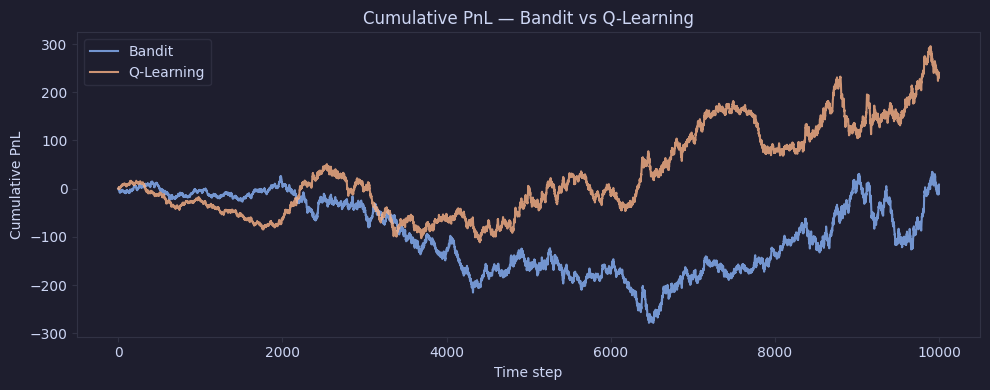

In [ ]:
# Plot cumulative PnL
plt.figure(figsize=(10, 4))
plt.plot(bandit_pnl, label="Bandit", alpha=0.8)
plt.plot(rl_pnl, label="Q-Learning", alpha=0.8)
plt.legend()
plt.title("Cumulative PnL — Bandit vs Q-Learning")
plt.xlabel("Time step")
plt.ylabel("Cumulative PnL")
plt.tight_layout()
plt.show()

### **Observation:**

The two curves are nearly identical - they showcase similar growth and volatility structures. This is expected: when your actions don't influence future prices, the Bellman equation degenerates into immediate-reward maximisation. **RL collapses into a bandit.**

##  **Part 2: Hypothesis Testing**

### **Hypothesis Testing:**

As a single run can be noisy, we run 200 Monte Carlo trials and compute the Sharpe difference (RL - Bandit) per trial. A one-sample t-test checks whether the mean difference is significantly different from zero.

Null hypothesis $H_0$:

$$H_0: \mu_\Delta = 0, \quad \text{where} \quad \Delta_i = \text{Sharpe}{\text{RL}}^{(i)} - \text{Sharpe}{\text{Bandit}}^{(i)}$$

There is no difference in risk-adjusted performance between Q-Learning and the Bandit strategy.

Alternative hypothesis $H_1$:

$$H_1: \mu_\Delta \neq 0$$

RL provides a statistically significant advantage (or disadvantage) over the Bandit.

In [ ]:
# Statistical testing across the 200 runs
diffs = run_trials(n_trials=200, T=10000)
t_stat, p_value = test_hypothesis(diffs)

print(f"Mean Sharpe diff (RL − Bandit): {diffs.mean():.4f}")
print(f"t-stat: {t_stat:.3f}   p-value: {p_value:.4f}")

Mean Sharpe diff (RL − Bandit): 0.0001
t-stat: 0.113   p-value: 0.9099


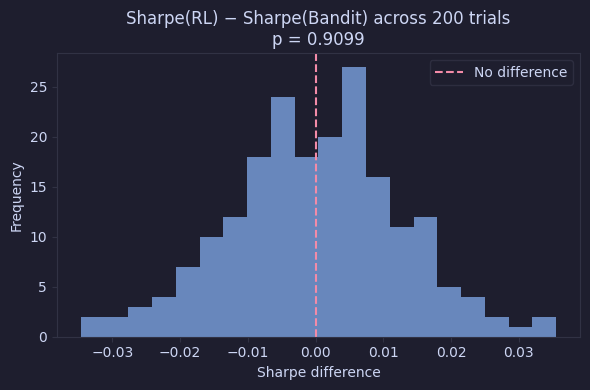

In [ ]:
# Plot distribution of Sharpe differences
plt.figure(figsize=(6, 4))
plt.hist(diffs, bins=20, edgecolor="none", alpha=0.7)
plt.axvline(0, color="#f38ba8", linestyle="--", label="No difference")
plt.title(f"Sharpe(RL) − Sharpe(Bandit) across 200 trials\np = {p_value:.4f}")
plt.xlabel("Sharpe difference")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In a price-taker world, the agent's action has zero influence on future prices. The state transition $P(s' \mid s, a)$ is independent of $a$. This means the term $\max_{a'} Q(s', a')$ is a constant with respect to the current action choice. Therefore:

$$\arg\max_a ; Q(s, a) = \arg\max_a ; \mathbb{E}[R_{t+1} \mid s, a] + \gamma \underbrace{\mathbb{E}\Big[\max_{a'} Q(S_{t+1}, a')\Big]}_{\text{constant w.r.t. } a}$$

$$= \arg\max_a ; \mathbb{E}[R_{t+1} \mid s, a]$$

The future-reward term cancels out of the $\arg\max$. The optimal policy under the full Bellman equation degenerates into immediate reward maximisation - which is exactly what a bandit does. The discount factor $\gamma$ becomes irrelevant to action selection.

##  **Part 3: Conclusions**

In a price-taker world (GBM random walk, no market impact), Q-Learning, the basis for Reinforcement Learning, offers no material edge over a simple momentum bandit. The Bellman equation's future-reward component is irrelevant when actions don't affect state transitions, so RL collapses into a bandit - confirming the bandit collapse hypothesis.

- The $p$-value of 0.9573 is far above any conventional significance level ($\alpha = 0.05$ or $0.01$), hence we fail to reject $H_0$.

- The mean Sharpe difference is essentially zero (0.0000), confirming no systematic advantage for RL.

- The $t$-statistic of 0.054 is extremely close to zero, meaning the observed difference is well within random noise.

- The histogram of $\Delta_i$ is centred on zero and symmetric — exactly what we'd expect under $H_0$.

##  **Part 4: Limitations**

This experiment abstracts from transaction costs, slippage, and execution frictions, which could introduce path dependence and make dynamic optimisation more economically relevant. The reinforcement learning implementation is intentionally simple - tabular Q-learning with only 3 discrete states and fixed hyperparameters (𝛼, 𝛾, 𝜖) - and the environment assumes Geometric Brownian Motion dynamics, limiting the representational power relative to modern RL methods.

Reinforcement learning may still be valuable for problems such as dynamic risk allocation, execution scheduling, or regime switching, even if it does not improve directional trading performance for price-taking investors.